# Measure the speed of tests with different numbers of processes and batch sizes

This Jupyter notebook measures the speed of tests with different numbers of processes and batch sizes.

## Experiment

In our experiment, we test 783 testfiles with the Markdown package for TeX at Git commit [`7613632`][1]. We test all combinations of the following parameters:

- Number of processes: 1, 2, 4, 8, 16, and 32
- Batch size: 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, and 1024

We measure the wall time for every set of parameters. To determine the median and confidence intervals, we repeat the test five times for every set of parameters.

By default, the test framework reduces the batch size with a large number of processes to ensure that all processes have batches to run. This minimizes wall time at the expense of CPU time. To see how the batch size cannibalizes off of the number of processes, we disabled the batch size limiting in our tests.

We used a machine with 80 Intel(R) Xeon(R) Gold 6230 CPUs clocked at 2.10 GHz and 400 GB RAM.

``` sh
./speed-tests.sh
```

 [1]: https://github.com/Witiko/markdown/commit/76136326e21f37084b6393bfc4efc17a1af4f377

In [1]:
! LC_ALL=C printf "The experiment ran for %.0f days.\n" "$(awk '{ print $7, $4 }' speed-tests.joblog | grep '^0 ' | awk '{ sum += $2 } END { print sum / 86400 }')"

The experiment ran for 33 days.


## Results

In this section, we discuss the results of the experiment.

In [2]:
from pathlib import Path
import re

In [3]:
number_of_samples = 5
results = {}
for path in Path('.').glob('speed-test-num_processes=*-batch_size=*.txt'):

    # Determine the parameters from the filename.
    match = re.match(r'speed-test-num_processes=(?P<num_processes>\d+)-batch_size=(?P<batch_size>\d+)\.txt', path.name)
    assert match is not None
    num_processes = match.group('num_processes')
    batch_size = match.group('batch_size')

    # Determine the wall times from the file contents.
    wall_times = []
    wall_times_maybe_corrupt = []
    assume_corrupt_output = False
    with path.open('rt') as f:
        for line in f:
            # If the test was killed by the OOM killer, we may or may not have recorded this test's wall time.
            if line.startswith('Command exited with non-zero status 137'):
                assume_corrupt_output = True
                continue
            match = re.search(r'system ((?P<hours>\d+):)?(?P<minutes>\d+):(?P<seconds>\d+(\.\d+)?)', line)
            if match is None:
                continue
            hours = match.group('hours')
            hours = 0 if hours is None else int(hours)
            minutes = int(match.group('minutes'))
            seconds = float(match.group('seconds'))
            total_seconds = hours * 3600 + minutes * 60 + seconds
            if assume_corrupt_output:
                wall_times_maybe_corrupt.append(total_seconds)
                assume_corrupt_output = False
            else:
                wall_times.append(total_seconds)

    # If we have fewer-than-expected wall times and some test was killed by the OOM killer, we assume we have not
    # recorded the test's wall time and we add the wall times we assumed may have originated from the killed test
    # to the set of wall times.
    assert len(wall_times) <= number_of_samples, (len(wall_times), path)
    if len(wall_times) < number_of_samples:
        wall_times += wall_times_maybe_corrupt
    assert len(wall_times) == number_of_samples

    results[num_processes, batch_size] = wall_times

First, we will display the median times for every set of parameters as a table:

In [4]:
%%capture
! pip install pandas

In [5]:
import pandas as pd
from IPython.display import display

In [6]:
df = pd.DataFrame([(k[0], k[1], median) for k, v in results.items() for median in [pd.Series(v).median()]],
                  columns=['num_processes', 'batch_size', 'median_time'])
pivot_table = df.pivot(index='num_processes', columns='batch_size', values='median_time')
pivot_table = pivot_table.applymap(lambda x: pd.to_timedelta(x, unit='s'))
pivot_table = pivot_table.sort_index(axis=0, key=lambda x: x.astype(int)).sort_index(axis=1, key=lambda x: x.astype(int))
display(pivot_table)

batch_size,1,2,4,8,16,32,64,128,256,512,1024
num_processes,,,,,,,,,,,
1,1 days 03:01:36,0 days 15:47:00,0 days 07:21:05,0 days 04:29:56,0 days 02:51:05,0 days 02:02:55,0 days 01:39:30,0 days 01:29:12,0 days 01:23:21,0 days 01:19:44,0 days 01:16:05
2,0 days 12:28:26,0 days 07:03:00,0 days 04:20:28,0 days 02:25:56,0 days 01:26:32,0 days 01:02:02,0 days 00:51:28.450000,0 days 00:45:53.540000,0 days 00:53:29.610000,0 days 00:45:56.110000,0 days 01:15:20
4,0 days 06:30:01,0 days 03:27:27,0 days 01:50:58,0 days 01:06:31,0 days 00:45:28.290000,0 days 00:34:13.610000,0 days 00:27:10.320000,0 days 00:32:52.160000,0 days 00:30:50.410000,0 days 00:44:23.040000,0 days 01:13:35
8,0 days 03:16:32,0 days 01:45:41,0 days 00:59:11.310000,0 days 00:36:30.090000,0 days 00:25:50.340000,0 days 00:19:46.660000,0 days 00:20:21.410000,0 days 00:21:14.590000,0 days 00:31:34.990000,0 days 00:45:34.360000,0 days 01:14:01
16,0 days 01:47:16,0 days 01:01:28,0 days 00:37:02.370000,0 days 00:27:29.960000,0 days 00:16:50.330000,0 days 00:14:10.950000,0 days 00:13:21.400000,0 days 00:21:20.090000,0 days 00:32:06.990000,0 days 00:45:20.870000,0 days 01:14:12
32,0 days 01:06:19,0 days 00:36:11.380000,0 days 00:21:41.030000,0 days 00:14:56.110000,0 days 00:10:42.830000,0 days 00:10:03.580000,0 days 00:13:30.140000,0 days 00:21:33.880000,0 days 00:34:33.780000,0 days 00:50:11.590000,0 days 01:24:15


In [7]:
%%capture
! pip install sympy

In [8]:
from sympy import symbols, Eq, solve

Next, we will determine the overhead of running tests for a single testfile:

In [9]:
num_testfiles = 783
no_batching_wall_time = pivot_table.loc['1', '1'].total_seconds()
single_batch_wall_time = pivot_table.loc['1', '1024'].total_seconds()
speed_up = no_batching_wall_time / single_batch_wall_time

In [10]:
X, Y = symbols('X Y')
eq1 = Eq(783 * (X + Y), no_batching_wall_time)
eq2 = Eq(X + 783 * Y, single_batch_wall_time)
solution = solve((eq1, eq2), (X, Y))

In [11]:
print(
    f'Running tests for a median testfile takes {solution[X] + solution[Y]:.0f} seconds out of which {solution[X]:.0f} seconds '
    f'({100 * solution[X] / (solution[X] + solution[Y]):.0f}%) are overhead of loading TeX formats, packages, fonts, and other resources.'
)
print(f'Batching testfiles gives up to {speed_up:.0f}x speed-up by amortizing the overhead.')

Running tests for a median testfile takes 124 seconds out of which 119 seconds (95%) are overhead of loading TeX formats, packages, fonts, and other resources.
Batching testfiles gives up to 21x speed-up by amortizing the overhead.


Finally, we will plot the wall times for the different sets of parameters.

In [12]:
%%capture
! pip install matplotlib

In [13]:
import matplotlib.pyplot as plt

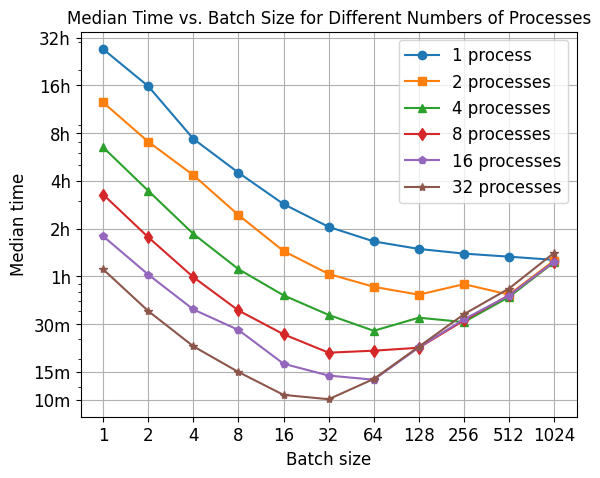

In [14]:
plt.figure(figsize=(6.4, 5))

markers = ['o', 's', '^', 'd', 'p', '*', 'x', '+', 'v', '<', '>', '|', '_']
batch_sizes = pivot_table.columns
for marker, num_processes in zip(markers, pivot_table.index):
    median_hours = [timedelta.total_seconds() / 3600 for timedelta in pivot_table.loc[num_processes]]
    label = f'{num_processes} process{"es" if int(num_processes) > 1 else ""}'
    plt.plot(batch_sizes, median_hours, label=label, marker=marker)

plt.xlabel('Batch size', fontsize=12)
plt.ylabel('Median time', fontsize=12)
plt.yscale('log')
plt.xticks(batch_sizes, fontsize=12)
plt.yticks([1/6, 0.25, 0.5, 1, 2, 4, 8, 16, 32], ['10m', '15m', '30m', '1h', '2h', '4h', '8h', '16h', '32h'], fontsize=12)
plt.title('Median Time vs. Batch Size for Different Numbers of Processes')
plt.legend(fontsize=12)
plt.grid(True)
_ = plt.savefig('speed-tests.pdf', dpi=600)